# Содержание
* [Описание проекта](#chapter0)
* [Шаг 1 - Загрузка табилц из SQL](#chapter3)
* [Шаг 2 - Первичное исследование таблиц](#step2)
* [Шаг 3 - Статистический анализ факторов ДТП](#step3)
    * [3.1 - ДТП по месяцам](#section_3_1)
    * [3.2 - Анализ серьёзности повреждений, исходя из состояния дороги](#section_3_2)
    * [3.3 - Самые частые причины ДТП](#section_3_3)
    * [3.4 - Связь удалённости от главной дороги и числа ДТП](#section_3_4)
    * [3.5 - Связь года выпуска авто и числа ДТП](#section_3_5)
    * [3.6 - Связь освещения и числа ДТП](#section_3_6)
    * [3.7 - Наиболее частые места ДТП](#section_3_7)
    * [3.8 - Наиболее частые типы машин, попадающих в ДТП](#section_3_8)
    * [3.9 - Частота проблем с устройством управления](#section_3_9)
* [Шаг 4 - Создание модели водительсткого риска](#step4)
    * [4.1 - Выбор и загрузка данных](#section_4_1)
    * [4.2 - Анализ и предобработка набора данных](#section_4_2)
    * [4.3 - Построение моделей без глубокого обучения](#section_4_3)
    * [4.4 - Построение модели глубокого обучения](#section_4_4)
* [Шаг 5 - Поиск лучшей модели](#step5)
    * [5.1 - Оптимизация архитерктуры модели с помощью библиотеки optuna](#section_5_1)
    * [5.2 - Подбор гипер-параметров](#section_5_2)
    * [5.3 - Сравнение результатов моделирования](#section_5_3)
* [Шаг 6 - Проверка лучшей модели](#step6)
* [Шаг 7 - Общий вывод по работе](#step7)

# Инструменты  
pandas  
numpy  
matplotlib  
sqlalchemy  
seaborn  
sklearn  
ydata_profiling  
pycaret  
fuzzywuzzy  
torch  
sklearn  
optuna  
shap  

## Описание проекта  <a name="chapter0"></a>


Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения для каршеринговой компании. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика: 
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

In [ ]:
!pip install squarify
!pip install pycaret
!pip install ydata-profiling
!pip install fuzzywuzzy
!pip install shap
!pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sqlalchemy import create_engine 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import squarify    # pip install squarify (algorithm for treemap)
import ydata_profiling
from pycaret.classification import *
from fuzzywuzzy import process
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import random
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score, accuracy_score, precision_score, precision_recall_curve
import sys

import optuna
from optuna.trial import TrialState
import shap

## Шаг 1: Загрузка табилц из SQL  <a name="chapter3"></a>

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string)

## Шаг 2 - Первичное исследование таблиц  <a name="step2"></a>

In [4]:
query = '''
SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns


'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,table_name,column_name,data_type
0,pg_partitioned_table,partstrat,"""char"""
1,pg_class,relhasrules,boolean
2,pg_class,relhastriggers,boolean
3,pg_class,relhassubclass,boolean
4,pg_class,relrowsecurity,boolean
...,...,...,...
1848,pg_attrdef,adbin,pg_node_tree
1849,pg_replication_slots,plugin,name
1850,pg_constraint,conname,name
1851,role_table_grants,is_grantable,character varying


Мы видим, что табилц в базе данных почти 2000, но нам предстоит работать тольк с 

In [5]:
query = '''
SELECT
table_name,
pg_size_pretty(table_size) AS table_size,
pg_size_pretty(indexes_size) AS indexes_size,
pg_size_pretty(total_size) AS total_size
FROM (
SELECT
table_name,
pg_table_size(table_name) AS table_size,
pg_indexes_size(table_name) AS indexes_size,
pg_total_relation_size(table_name) AS total_size
FROM (
SELECT ('"' || table_schema || '"."' || table_name || '"') AS table_name
FROM information_schema.tables
WHERE table_schema='public'
) AS all_tables
ORDER BY total_size DESC
) AS pretty_sizes

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs


,table_name,table_size,indexes_size,total_size
0,"""public"".""parties""",246 MB,59 MB,305 MB
1,"""public"".""collisions""",302 MB,0 bytes,302 MB
2,"""public"".""case_ids""",59 MB,30 MB,89 MB
3,"""public"".""vehicles""",63 MB,22 MB,85 MB


- Все необхоидмые для нашего проекта табилцы представлены.
- Во всех интересующих нас таблицах достаточно много данных, другой вопрос какого они качества, но с этим мы будем разбираться позже. 

In [6]:
query = '''
SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE table_name='collisions'

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,table_name,column_name,data_type
0,collisions,party_count,integer
1,collisions,intersection,integer
2,collisions,distance,real
3,collisions,collision_date,date
4,collisions,collision_time,time without time zone
5,collisions,location_type,text
6,collisions,collision_damage,text
7,collisions,case_id,text
8,collisions,pcf_violation_category,text
9,collisions,type_of_collision,text


Беглый взгляд на структуру таблицы "столкновений" позволяет сказать, что:

- 1. есть индекс, который скорее всего связывает все таблицы
- 2. 18 признаков из которых как минимум 1 числовой, а остальные категориальные. Есть ещё 2 временных признака, которые тоже скорее всего будут категориальными по своей роли в моделировании.

In [7]:
query = '''
SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE table_name='vehicles'

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,table_name,column_name,data_type
0,vehicles,id,integer
1,vehicles,party_number,integer
2,vehicles,vehicle_age,integer
3,vehicles,case_id,text
4,vehicles,vehicle_type,text
5,vehicles,vehicle_transmission,text


Беглый взгляд на структуру таблицы "транспортных средств" позволяет сказать, что:

- 1. есть индекс, который скорее всего связывает все таблицы
- 2. каждое тренспортное средство описано типом кузово, коробки передач и пробегом, который для нас особенно критичен из-за требования заказчика

In [8]:
query = '''
SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE table_name='parties'

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,table_name,column_name,data_type
0,parties,cellphone_in_use,integer
1,parties,party_number,integer
2,parties,at_fault,integer
3,parties,insurance_premium,integer
4,parties,id,integer
5,parties,case_id,text
6,parties,party_drug_physical,text
7,parties,party_type,text
8,parties,party_sobriety,text


Беглый взгляд на структуру таблицы "водителей" позволяет сказать, что:

- 1. есть индекс, который скорее всего связывает все таблицы
- 2. все "водители"  хараткеризуются 4 категориальными признаками, и целевой метрикой - виностностью в ДТП,есть ещё величина страховки, её роль в нашей модели пока не ясна.

In [9]:
query = '''
SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE table_name='case_ids'

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,table_name,column_name,data_type
0,case_ids,case_id,text
1,case_ids,db_year,text


В этой таблице всего два поля, зато там есть год инцидента, который позволит отобрать нам для моделирования только те случаи, которые наиболее релевантны. Ибо дорожная обстановка за год может поменяться достаточно существенно. Например откроют новой транспортное кольцо.

In [10]:
query = '''
SELECT 
*
FROM case_ids
LIMIT 5

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [11]:
query = '''
SELECT 
*
FROM collisions
LIMIT 5

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [12]:
query = '''
SELECT 
*
FROM vehicles
LIMIT 5

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [13]:
query = '''
SELECT 
*
FROM parties
LIMIT 5

'''
tabs= pd.read_sql_query(query, con=engine) 
tabs

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Теперь мы посмотрели как выглядит каждая из табилц. Можем теперь от форме перейти к интересным моментам в содержании.

## Шаг 3 - Статистический анализ факторов ДТП  <a name="step3"></a>

### 3.1 - ДТП по месяцам  <a name="section_3_1"></a>

Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений (таблица collisions).

In [14]:
query = '''
SELECT DISTINCT
EXTRACT(YEAR FROM COLLISION_DATE) as YEAR,
EXTRACT(MONTH FROM COLLISION_DATE) AS MONTH,
date_trunc('month', COLLISION_DATE) as happened_on,
COUNT (case_id)  as cnt
FROM collisions
GROUP BY YEAR, MONTH, happened_on
ORDER BY happened_on;

'''
collisions= pd.read_sql_query(query, con=engine) 
collisions

,year,month,happened_on,cnt
0,2009.0,1.0,2009-01-01 00:00:00+03:00,35062
1,2009.0,2.0,2009-02-01 00:00:00+03:00,34480
2,2009.0,3.0,2009-03-01 00:00:00+03:00,36648
3,2009.0,4.0,2009-04-01 00:00:00+04:00,35239
4,2009.0,5.0,2009-05-01 00:00:00+04:00,36916
5,2009.0,6.0,2009-06-01 00:00:00+04:00,34202
6,2009.0,7.0,2009-07-01 00:00:00+04:00,35161
7,2009.0,8.0,2009-08-01 00:00:00+04:00,34508
8,2009.0,9.0,2009-09-01 00:00:00+04:00,35555
9,2009.0,10.0,2009-10-01 00:00:00+04:00,37835


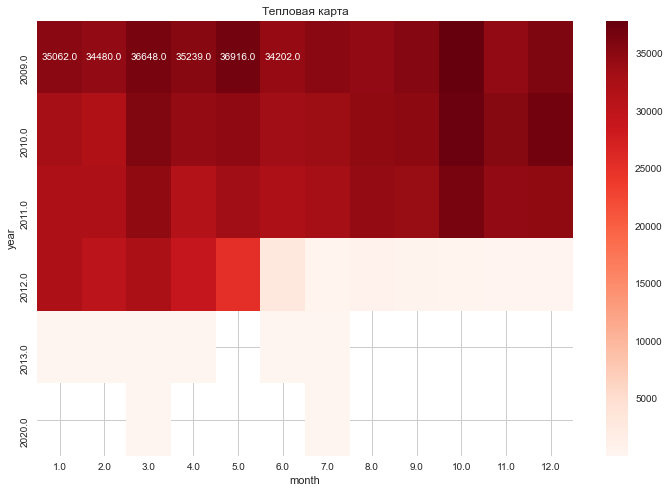

In [17]:
heat = collisions.pivot('year', 'month', 'cnt')
plt.figure(figsize=(12, 8)) # задаём размер графика
sns.heatmap(heat, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='', cmap='Reds') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 


Тепловая карта позволяет слазу сказать, что:
- 1. Данные после 2012 года покрывают не все месяцы. Можено конечно допустить, что там ДТП не было, но это вряд ли.
- 2. Количество ДТП плавно снижается год от года, вероятная причина - сокращение парка машин по мере "естественной убыли".
- 3. Наблюдется чётко-различимая полоса в октябре, когда число ДТП больше обычного. В большинсвте лет, когда статистика идёт без аномалий.

In [18]:
heat=heat.iloc[0:-2]

heat

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
year,,,,,,,,,,,,
2009.0,35062.0,34480.0,36648.0,35239.0,36916.0,34202.0,35161.0,34508.0,35555.0,37835.0,34562.0,36060.0
2010.0,32892.0,31918.0,35803.0,34416.0,34862.0,33367.0,33645.0,34620.0,34957.0,37480.0,35460.0,37070.0
2011.0,31926.0,31975.0,34585.0,31377.0,33370.0,31962.0,33029.0,34339.0,34137.0,36618.0,34495.0,34615.0
2012.0,32020.0,30377.0,32498.0,29143.0,25168.0,3062.0,390.0,622.0,510.0,304.0,253.0,200.0


<Figure size 576x432 with 0 Axes>

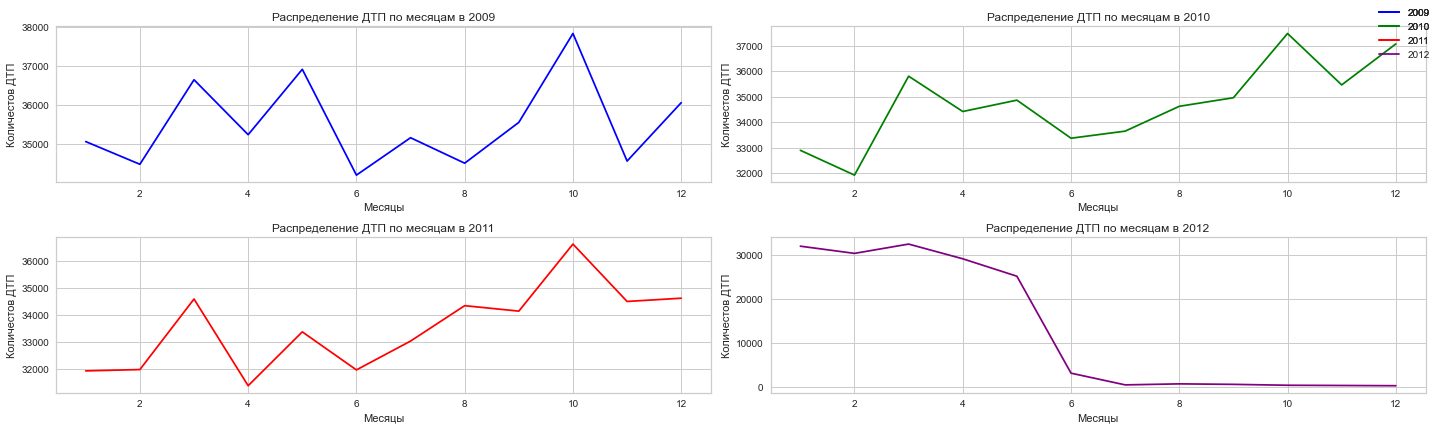

In [23]:
x=np.array(heat.columns)
# Set Seaborn style
plt.figure(figsize=(8, 6))
colors=['blue','green','red','purple']
year=[2009,2010,2011,2012]
# Две строки, два столбца. Текущая ячейка - 1
f, axs = plt.subplots(2, 2, figsize=(20, 6),layout='tight')
sp={0:[0,0],1:[0,1],2:[1,0],3:[1,1]}
for i in range(len(heat)):
    y=np.array(heat.iloc[i])
    # Две строки, два столбца. Текущая ячейка - 1
    axs[sp[i][0], sp[i][1]].plot( x,y, color=colors[i], label=year[i])
    axs[sp[i][0], sp[i][1]].set(xlabel ="Месяцы", ylabel = "Количестов ДТП", title ='Распределение ДТП по месяцам в '+str(year[i]))
    f.legend()

f.show()


**Вывод**

У нас есть три "типовых" года, когда просматривается чёткий пик количества ДТП в октябре. При этом в 2012 году с июня наблюдается резкая просадка количества аварий, как будто компания продала половину автопарка или перестала вести статистику по ДТП. Так что в 2012 году - пик это март, после которого натсупает явно неестественное сокращение к нулевым отметкам.

Это и логично. В октябре у нас начинаются первые заморозки, не все успевают поменять резину и это приводит к большему чем обычно количеству аварий.

Также количество ДТП возрастает в марте, мае и декабре. Возможно это связано с праздниками, после которых водители могут сесть за руль даже не вполне трезвыми.

В летние месяцы количество аварий традиционно на минимуме, как и в феврале (видимо так как месяц короткий и холодный, вообще никуда лучше не ездить).
Можно предположить, что спад ДТП в ноябре как раз связан с тем, что много машин побилось в октябре и большую часть месяца - в ремонте.

In [24]:
heat=heat.drop([2012.0],axis=0)
heat.append(heat.sum(numeric_only=True), ignore_index=True)
heat.loc['total']=heat.sum(numeric_only=True)
heat

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
year,,,,,,,,,,,,
2009.0,35062.0,34480.0,36648.0,35239.0,36916.0,34202.0,35161.0,34508.0,35555.0,37835.0,34562.0,36060.0
2010.0,32892.0,31918.0,35803.0,34416.0,34862.0,33367.0,33645.0,34620.0,34957.0,37480.0,35460.0,37070.0
2011.0,31926.0,31975.0,34585.0,31377.0,33370.0,31962.0,33029.0,34339.0,34137.0,36618.0,34495.0,34615.0
total,99880.0,98373.0,107036.0,101032.0,105148.0,99531.0,101835.0,103467.0,104649.0,111933.0,104517.0,107745.0


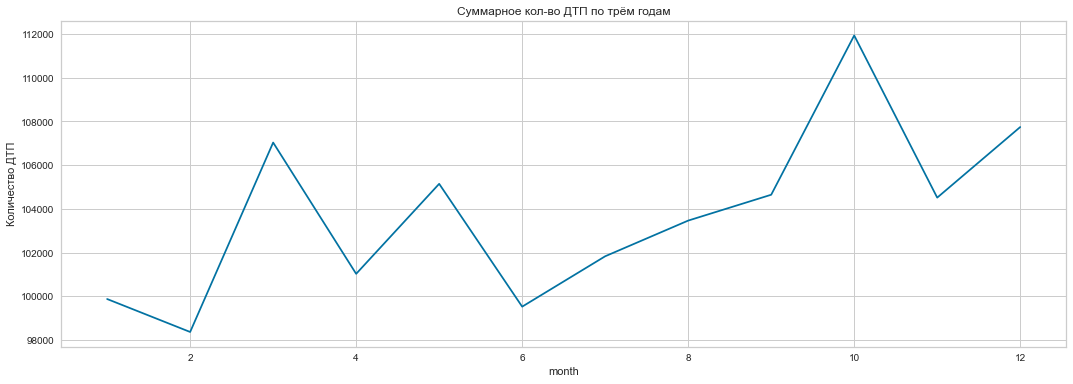

In [27]:
plt.figure(figsize=(18, 6))
heat.iloc[-1].plot()
plt.title('Суммарное кол-во ДТП по трём годам')
plt.ylabel("Количество ДТП")
plt.show()

Граффик суммарного количества ДТП по трём годам, когда наши данные выглядят наиболее полными подвтерждает гипотезу об экстремуме в октябре, и трёх локальных пиках в декабре, марте и мае, а также минимум ДТП в феврале и июне.

### 3.2 - Анализ серьёзности повреждений, исходя из состояния дороги  <a name="section_3_2"></a>

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП.

In [28]:
query = '''
SELECT 
ROAD_SURFACE,
ROAD_CONDITION_1,
COLLISION_DAMAGE,
c.CASE_ID
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
WHERE party_type='car';
'''
collisions= pd.read_sql_query(query, con=engine) 
collisions

,road_surface,road_condition_1,collision_damage,case_id
0,wet,normal,small damage,4021529
1,wet,normal,small damage,4021668
2,wet,normal,small damage,4035225
3,dry,normal,small damage,4035651
4,dry,normal,scratch,4036224
...,...,...,...,...
2469309,dry,normal,small damage,5456544
2469310,dry,normal,severe damage,5456579
2469311,dry,normal,small damage,5456610
2469312,dry,normal,middle damage,5456619


In [29]:
heat=pd.pivot_table(collisions,
                index=[ "road_condition_1","road_surface",],
                columns=["collision_damage"],
                values=["case_id"],
                aggfunc='count')
heat

case_id                                        \
collision_damage                 fatal middle damage   scratch severe damage   
road_condition_1 road_surface                                                  
construction     dry             303.0        3235.0    9134.0         615.0   
                 slippery          NaN          13.0      16.0           NaN   
                 snowy             NaN           3.0      18.0           5.0   
                 wet              27.0         142.0     570.0          32.0   
flooded          dry               1.0          20.0      53.0           NaN   
                 slippery          NaN           5.0       2.0           1.0   
                 snowy             NaN           4.0       4.0           NaN   
                 wet               6.0         159.0     357.0          26.0   
holes            dry              24.0         558.0    1258.0         106.0   
                 slippery          1.0          13.0      15.0           2.0   
                 snowy             NaN          23.0      41.0           6.0   
                 wet               6.0          29.0      95.0           8.0   
loose material   dry              40.0         486.0     563.0         119.0   
                 slippery          NaN          39.0      36.0          10.0   
                 snowy             3.0          15.0      31.0           6.0   
                 wet               2.0          59.0      77.0          12.0   
normal           dry           13863.0      228987.0  590648.0       38920.0   
                 slippery         11.0         146.0     331.0          47.0   
                 snowy            61.0         817.0    1479.0         207.0   
                 wet            1153.0       19009.0   59132.0        3430.0   
obstruction      dry              69.0         700.0    1537.0         147.0   
                 slippery          NaN           2.0      13.0           3.0   
                 snowy             NaN           9.0       7.0           1.0   
                 wet               5.0          60.0     206.0          32.0   
other            dry              52.0         654.0    1240.0         143.0   
                 slippery          6.0          67.0      78.0          14.0   
                 snowy             2.0          73.0     177.0          19.0   
                 wet              15.0         168.0     504.0          37.0   
reduced width    dry              11.0         152.0     336.0          30.0   
                 slippery          NaN           NaN       1.0           NaN   
                 snowy             NaN          19.0      40.0           NaN   
                 wet               NaN          16.0      47.0           1.0   

                                            
collision_damage              small damage  
road_condition_1 road_surface               
construction     dry               22461.0  
                 slippery             62.0  
                 snowy                50.0  
                 wet                1432.0  
flooded          dry                  75.0  
                 slippery             11.0  
                 snowy                10.0  
                 wet                 835.0  
holes            dry                2836.0  
                 slippery             62.0  
                 snowy               183.0  
                 wet                 318.0  
loose material   dry                1678.0  
                 slippery             96.0  
                 snowy                71.0  
                 wet                 286.0  
normal           dry             1270201.0  
                 slippery            638.0  
                 snowy              5443.0  
                 wet              132822.0  
obstruction      dry                4847.0  
                 slippery             29.0  
                 snowy                35.0  
                 wet                 543.0  
other          

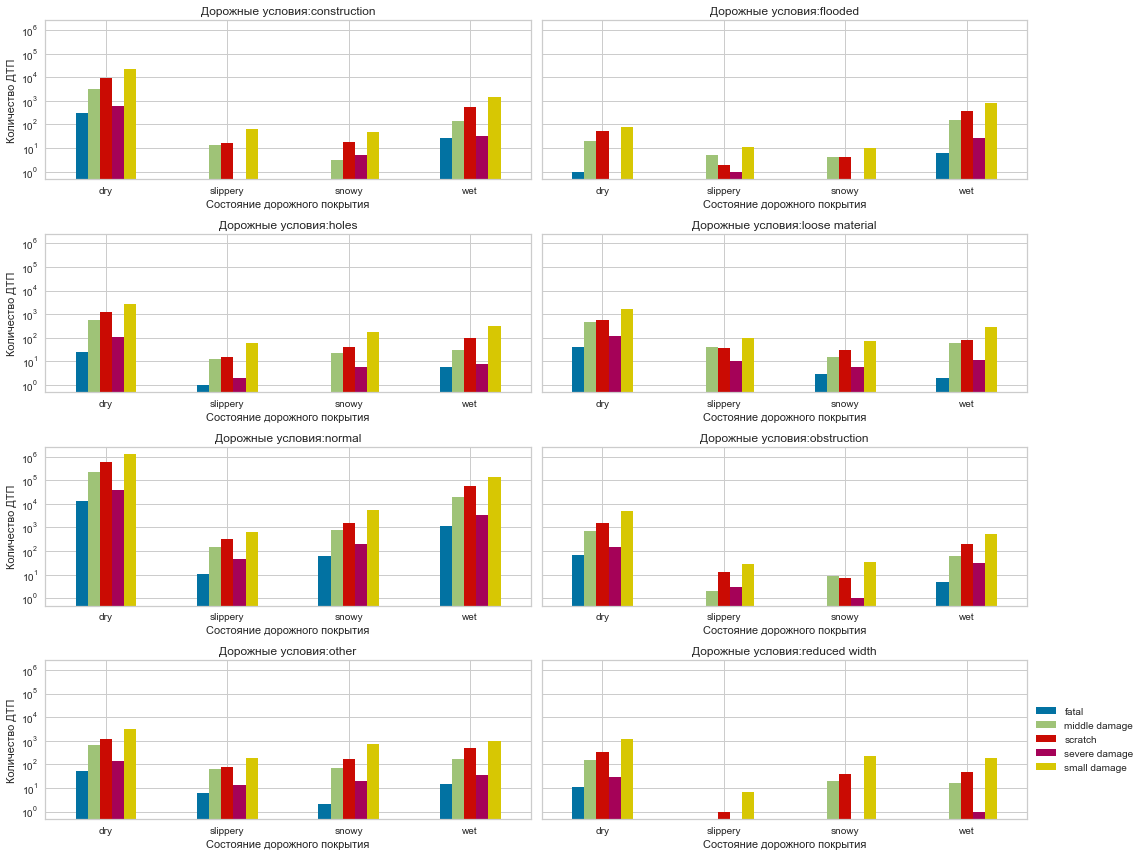

In [33]:
conds=['construction','flooded','holes','loose material','normal','obstruction','other','reduced width']
fig, axes = plt.subplots(nrows=4, ncols=2,sharey=True)
x=0
y=0
for i in conds:
    da=heat.loc[i]
    da.columns = da.columns.get_level_values(1)
    da.plot(ax=axes[x,y],kind='bar',logy=True,title="Дорожные условия:"+i,figsize=(16,12),legend=False, rot=0)
    axes[x,y].set(ylabel='Количество ДТП')
    axes[x,y].set(xlabel='Состояние дорожного покрытия')
    y=y+1
    if y==2:
        x=x+1
        y=0
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
fig.show()

Благодаря графикам становится понятно, что никакой тип дороги и никакие погодные условия не гарантирую от ДТП. Даже на сухой дороге в нормальном состоянии аварии случаются, и случаются чаще. Это неизбежно, потому что именно по таким дорогам и ездят на каршеринговых машинах. Очевидно, основные проблемы всё-таки не в дорогах, а в дураках.

Другой интересный факт - на заснеженных и скользких дорогах бьются меньше чем на мокрых. Видимо, это из-за того что в дождь ещё и видимость хуже. Да и много ли снега в той Америке?

### 3.3 - Самые частые причины ДТП  <a name="section_3_3"></a>

In [34]:
query = '''
SELECT DISTINCT
PARTY_DRUG_PHYSICAL,
PARTY_SOBRIETY,
CELLPHONE_IN_USE,
PRIMARY_COLLISION_FACTOR,
COUNT (c.case_id) OVER (ORDER BY PARTY_DRUG_PHYSICAL,primary_collision_factor) as drugged_reason,
COUNT (c.case_id) OVER (ORDER BY PARTY_SOBRIETY,primary_collision_factor) as drunked_reason,
COUNT (c.case_id) OVER (ORDER BY CELLPHONE_IN_USE,primary_collision_factor) as phone_reason,
COUNT (c.case_id) OVER (ORDER BY primary_collision_factor) as total
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
WHERE AT_FAULT=1 ;
'''
collisions= pd.read_sql_query(query, con=engine) 
collisions

,party_drug_physical,party_sobriety,cellphone_in_use,primary_collision_factor,drugged_reason,drunked_reason,phone_reason,total
0,impairment - physical,"had been drinking, under influence",NaN,vehicle code violation,184598,134942,1288127,1288127
1,impairment - physical,None,NaN,other improper driving,182769,1259574,1065638,6544
2,sleepy/fatigued,"had been drinking, not under influence",1.0,vehicle code violation,209465,28996,1063786,1288127
3,sleepy/fatigued,None,1.0,other improper driving,197548,1259574,1039110,6544
4,sleepy/fatigued,had not been drinking,0.0,other improper driving,197548,139502,4596,6544
...,...,...,...,...,...,...,...,...
106,None,had not been drinking,0.0,vehicle code violation,1288127,1063762,1039014,1288127
107,under drug influence,None,0.0,other improper driving,209477,1259574,4596,6544
108,under drug influence,"had been drinking, impairment unknown",0.0,vehicle code violation,221626,17052,1039014,1288127
109,under drug influence,None,1.0,vehicle code violation,221626,1288127,1063786,1288127


In [35]:
data=collisions[['primary_collision_factor','total']]
data=data.drop_duplicates()
data

,primary_collision_factor,total
0,vehicle code violation,1288127
1,other improper driving,6544
30,fell asleep,47


Сразу ясно, что кроме нарушения правил дорожного движения, остальные причины встречаются исчезающе редко.
Проанализируем эту группу более подробно.

In [36]:
query = '''
SELECT 
PARTY_SOBRIETY,
COUNT (c.case_id) 
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
WHERE AT_FAULT=1 
GROUP BY PARTY_SOBRIETY;
'''

data=pd.read_sql_query(query, con=engine) 

data

,party_sobriety,count
0,"had been drinking, impairment unknown",17052
1,"had been drinking, not under influence",11944
2,"had been drinking, under influence",105946
3,had not been drinking,928820
4,impairment unknown,182724
5,not applicable,12801
6,None,28840


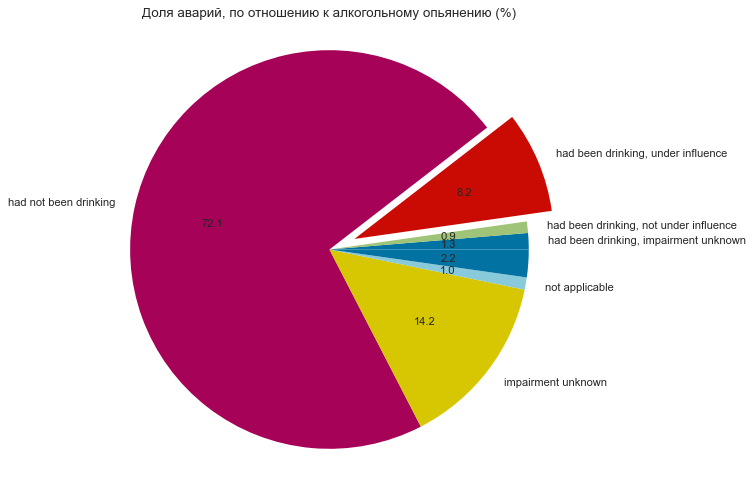

In [37]:
data_names = list(data['party_sobriety'])
data_val = list(data['count'])
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )


plt.title('Доля аварий, по отношению к алкогольному опьянению (%)')

plt.pie(
    data_val, labels = data_names, autopct='%.1f', radius = 1.1,
    explode = [0,0,0.15,0,0,0,0] )

fig.show()


Видно, что лишь около 8.2% аварий с участием пьяных водителей, и около 1,4% из них - с теми употреблял, но либо уже не под воздействием, либо неизвестно.

In [38]:
query = '''
SELECT 
party_drug_physical,
COUNT (c.case_id) 
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
WHERE AT_FAULT=1 
GROUP BY party_drug_physical;
'''

data=pd.read_sql_query(query, con=engine) 
data=data.sort_values(by=['count'],ascending=False)
data

,party_drug_physical,count
5,None,1066501
0,G,182724
2,not applicable,12801
4,under drug influence,12161
3,sleepy/fatigued,12066
1,impairment - physical,1874


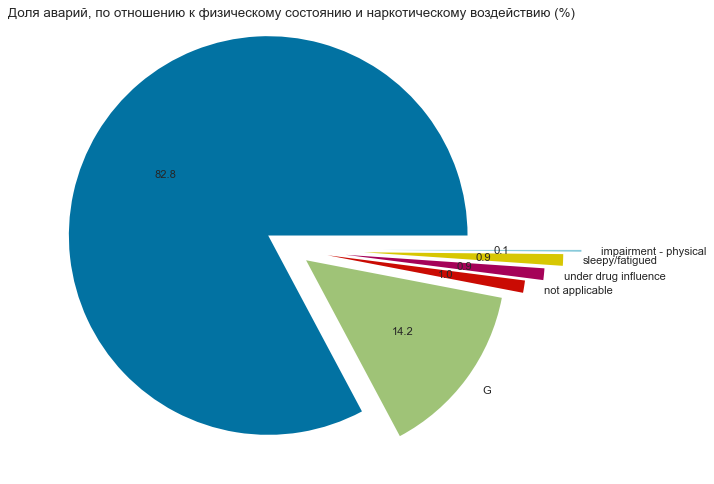

In [39]:
data_names = list(data['party_drug_physical'])
data_val = list(data['count'])
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )


plt.title('Доля аварий, по отношению к физическому состоянию и наркотическому воздействию (%)')

plt.pie(
    data_val, labels = data_names, autopct='%.1f', radius = 1.1,
    explode = [0.15,0.1,0.2,0.3,0.4,0.5],rotatelabels=False )

fig.show()

Прочие физиологические причины аварий менее вырожены, почти 1% попадают в аварии под наркотиками, столько же - засыпают за рулём, около 0,1% - испытывают иное ухудшение физического состояния. Но подавляющее большинство аварий всё-таки происходит без участия веществ или недомогания. 

In [40]:
query = '''
SELECT DISTINCT
CELLPHONE_IN_USE,
COUNT (c.case_id)  as cases
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
GROUP BY CELLPHONE_IN_USE;
'''
collisions= pd.read_sql_query(query, con=engine) 

collisions

,cellphone_in_use,cases
0,0.0,2194946
1,1.0,45825
2,NaN,511637


Про сотовые телефоны сказать трудно. Аварии где они были использованы встречаются достаточно редко, но это не говорит о том, что они позволяют избегать ДТП. Так что сравним их с тяжестью аварии:

In [41]:
query = '''
SELECT DISTINCT
CELLPHONE_IN_USE,
collision_damage,
COUNT (p.CASE_ID)
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
GROUP BY CELLPHONE_IN_USE,collision_damage;
'''
collisions= pd.read_sql_query(query, con=engine) 

collisions

,cellphone_in_use,collision_damage,count
0,0.0,fatal,16216
1,0.0,middle damage,253169
2,0.0,scratch,594408
3,0.0,severe damage,45439
4,0.0,small damage,1285714
5,1.0,fatal,321
6,1.0,middle damage,4736
7,1.0,scratch,12318
8,1.0,severe damage,842
9,1.0,small damage,27608


Text(0.5, 1.0, 'Телефон используется')

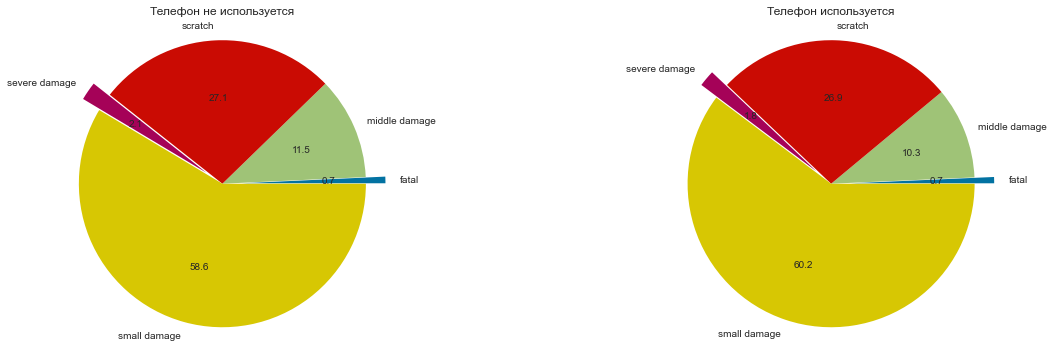

In [42]:
cell0=collisions.loc[collisions['cellphone_in_use']==0.0]
cell1=collisions.loc[collisions['cellphone_in_use']==1.0]
f, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot (1, 2,1)
data_val0=cell0['count']
data_names0=cell0['collision_damage']
plt.pie(
    data_val0, labels = data_names0, autopct='%.1f', radius = 1.1,
    explode = [0.15,0,0,0.15,0],rotatelabels=False )
plt.title('Телефон не используется')
plt.subplot (1, 2,2)
data_val1=cell1['count']
data_names1=cell1['collision_damage']
plt.pie(
    data_val1, labels = data_names1, autopct='%.1f', radius = 1.1,
    explode = [0.15,0,0,0.15,0],rotatelabels=False )
plt.title('Телефон используется')

Мы видимо что число аварий где телефон используется гораздо меньше, при этом процент фатальных и серьёзных повреждений остаётся почти на том же уровне, да и остальные доли имеют откланеия в пару процентов. Для того чтобы доказать здесь какую-то взаимосвязь понадобятся более серьёзныне исследования.

Изучим теперь, какие же именно нарушения правил встречаются наиболее часто:

In [43]:
query = '''
SELECT DISTINCT
PCF_VIOLATION_CATEGORY,
COUNT (c.case_id)  as cases
FROM collisions c 
GROUP BY PCF_VIOLATION_CATEGORY;
'''
collisions= pd.read_sql_query(query, con=engine) 
collisions=collisions.sort_values(by=['cases'],ascending=False).head(15)
collisions

,pcf_violation_category,cases
17,speeding,438439
8,improper turning,238987
0,automobile right of way,158291
2,dui,110476
20,unsafe lane change,93962
18,traffic signals and signs,72751
21,unsafe starting or backing,55674
19,unknown,39558
22,wrong side of road,33631
4,following too closely,30033


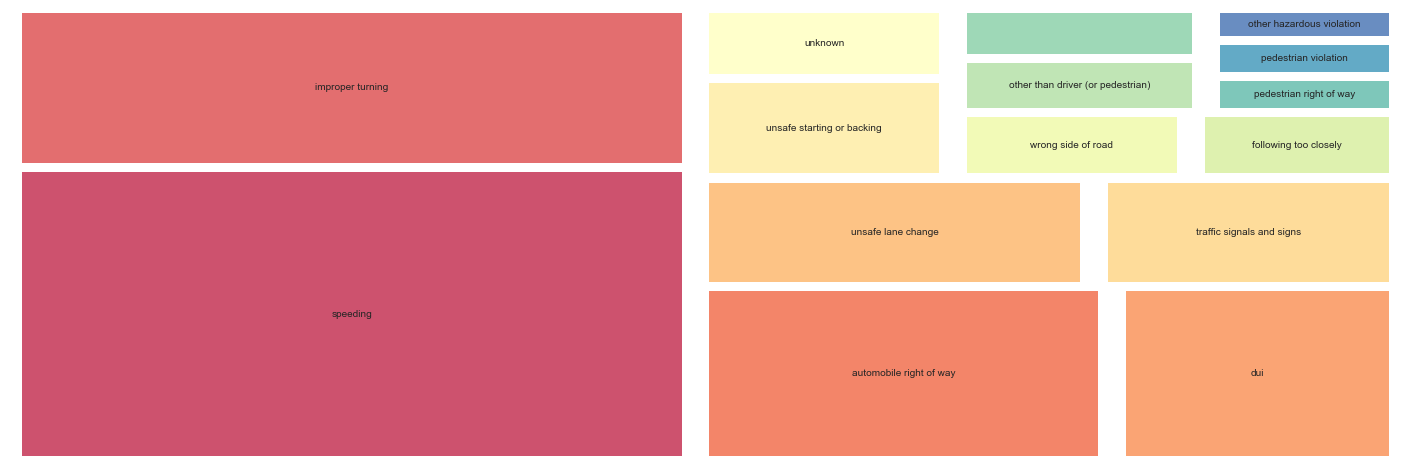

In [44]:

# plot it
fig = plt.figure(dpi = dpi, figsize = (1800 / dpi, 600 / dpi) )
squarify.plot(sizes=collisions['cases'], label=collisions['pcf_violation_category'], alpha=.8 ,color=sns.color_palette("Spectral",len(collisions)),pad=0.5,text_kwargs={'fontsize': 9,'wrap':True})
plt.axis('off')
plt.show()

На графике сразу видно, что все проблемы от превышения скорости и о того, что повортники не включают. Пренебрегают правом проезда тоже достаточно часто. Замыкают четвёркую лидеров - нетрезвое вождение.

### 3.4 - Связь удалённости от главной дороги и числа ДТП  <a name="section_3_4"></a>

Определим есть ли какая-то связь между удалённостью от главной дороги и количеством аварий.
- Сделаем выгрузку из SQL.
- Посчитаетм число ДТП по удалённости от главной дороги.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [45]:
query = '''
SELECT
c.case_id,
distance
FROM collisions c ;
'''
collisions= pd.read_sql_query(query, con=engine) 
collisions=collisions.sort_values(by=['distance'],ascending=False)
collisions

,case_id,distance
1320853,5282502,8363520.0
907380,5095709,5607360.0
500773,4229506,3263040.0
106273,4489425,2851200.0
1268755,4761234,2735040.0
...,...,...
95284,4451797,0.0
1099335,5488010,0.0
417878,5638477,0.0
744975,4756930,0.0


In [46]:
collisions['distance'].mean()

660.7115159999997

In [47]:
max=collisions['distance'].max()
step=max/10
collisions['cluster_label']=round(collisions['distance']/step)

collisions

,case_id,distance,cluster_label
1320853,5282502,8363520.0,10.0
907380,5095709,5607360.0,7.0
500773,4229506,3263040.0,4.0
106273,4489425,2851200.0,3.0
1268755,4761234,2735040.0,3.0
...,...,...,...
95284,4451797,0.0,0.0
1099335,5488010,0.0,0.0
417878,5638477,0.0,0.0
744975,4756930,0.0,0.0


In [48]:
rez=pd.pivot_table(collisions,
               index=["cluster_label"],
               values=["distance"],
               aggfunc='count')
rez

,distance
cluster_label,
0.0,1399963
1.0,23
2.0,4
3.0,7
4.0,1
7.0,1
10.0,1


Тут и без графиков ясно, что почти все ДТП случаются именно на главной дороге или в незначительном удалении от неё.

### 3.5 - Связь года выпуска авто и числа ДТП  <a name="section_3_5"></a>

Определим есть ли есть ли связь между годом выпуска авто и количеством аварий.
- Сделаем выгрузку из SQL.
- Посчитаетм число ДТП по годам выпуска авто.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [49]:
query = '''
SELECT DISTINCT
VEHICLE_AGE,
COUNT(id)  as cnt FROM 
(SELECT 
    VEHICLE_AGE,
    party_type,
    AT_FAULT,
    c.CASE_ID as id
    FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID  JOIN Vehicles v ON v.CASE_ID=p.CASE_ID
    WHERE v.party_number=p.party_number
    ) Nina
    WHERE AT_FAULT=1 AND party_type='car' 
    GROUP BY VEHICLE_AGE
    ORDER BY VEHICLE_AGE
'''
collisions= pd.read_sql_query(query, con=engine) 
collisions

,vehicle_age,cnt
0,0.0,16569
1,1.0,14481
2,2.0,50252
3,3.0,91666
4,4.0,52717
5,5.0,38172
6,6.0,28039
7,7.0,27021
8,8.0,24341
9,9.0,18765


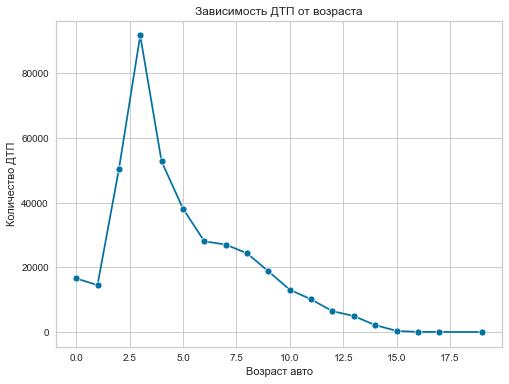

In [50]:
collisions.drop(collisions.tail(2).index,inplace=True)
plt.figure(figsize=(8, 6)) # Width and Height of the chart
sns.lineplot(x='vehicle_age',
             y='cnt',
             data=collisions,
             marker='o', # Style used to mark the join between 2 points
            )
plt.xlabel('Возраст авто') # x-axis name
#plt.yscale("log")
plt.ylabel('Количество ДТП') # y-axis name
plt.title('Зависимость ДТП от возраста') # Add a title
plt.show() # Display the graph


График показывает, что есть чётки пик ДТП между 2,5 и 5 годами возраста автомобиля. Это может быть связано с тем, что подавляющее большинство машин в автопарке покупались одновременно и им усреднённо 3 года, после этого идёт резкое снижение, которое с годами становися всё более плавным, а после 15 лет вообще исчезающе мало.

### 3.6 - Связь освещения и числа ДТП  <a name="section_3_6"></a>

Определим есть ли есть ли связь между освещённостью и количеством аварий.
- Сделаем выгрузку из SQL.
- Посчитаетм число ДТП по категориям освещённости.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [51]:
query = '''
SELECT DISTINCT
LIGHTING,
COUNT(c.CASE_ID)  as cnt
FROM collisions c
GROUP BY LIGHTING
ORDER BY cnt DESC
'''
collisions2= pd.read_sql_query(query, con=engine) 
#Удалим пропуски
#collisions2.drop(collisions.tail(1).index,inplace=True)
collisions2

,lighting,cnt
0,daylight,941950
1,dark with street lights,291887
2,dark with no street lights,106170
3,dusk or dawn,47199
4,None,8593
5,dark with street lights not functioning,4201


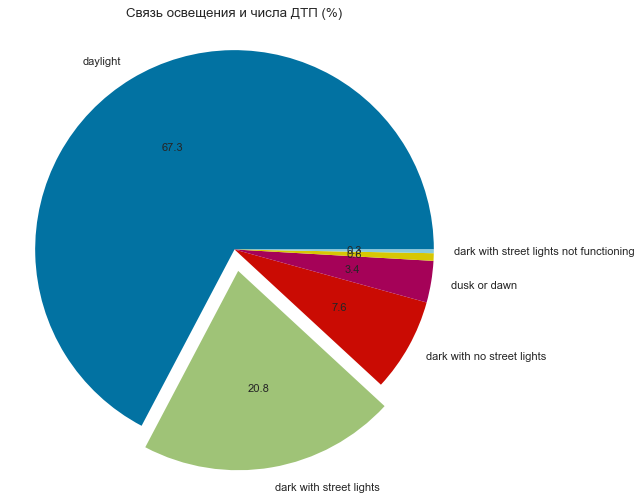

In [52]:
data_names = list(collisions2['lighting'])
data_val = list(collisions2['cnt'])
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )


plt.title('Связь освещения и числа ДТП (%)')

plt.pie(
    data_val, labels = data_names, autopct='%.1f', radius = 1.1,
    explode = [0,0.12,0,0,0,0],rotatelabels=False )

fig.show()

Большинство конечно при свете дня, но с доля ночных ДТП тоже достаточно существенна, случаи кода ДТП ночью в неосвещённом районе встречаются крайне редко. Видимо проблема всё-таки в людях в первую очередь.

### 3.7 - Наиболее частые места ДТП  <a name="section_3_7"></a>

Определим где наши машины бьются больше всего.
- Сделаем выгрузку из SQL.
- Посчитаетм число ДТП по локациям.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [53]:
query = '''
SELECT DISTINCT
LOCATION_TYPE,
COUNT(c.CASE_ID)  as cnt
FROM collisions c
GROUP BY LOCATION_TYPE
ORDER BY LOCATION_TYPE
'''
collisions= pd.read_sql_query(query, con=engine) 
#Удалим пропуски
collisions


,location_type,cnt
0,highway,416531
1,intersection,26656
2,ramp,75592
3,None,881221


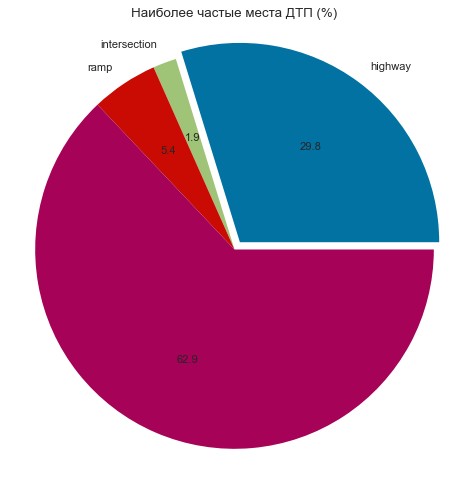

In [54]:
data_names = list(collisions['location_type'])
data_val = list(collisions['cnt'])
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1000 / dpi, 600 / dpi) )


plt.title('Наиболее частые места ДТП (%)')

plt.pie(
    data_val, labels = data_names, autopct='%.1f', radius = 1.1,
    explode = [0.05,0,0,0],rotatelabels=False )

fig.show()

Про места большинтсва аварий мы ничего не знаем. Но из тех, про которые данные есть в базе, с большим отрывом лидирует "шоссе". Да и для нужд моделирования этот фактор не особо подойдёт,потому как узнать его можно только после того как авария случилась.

In [55]:
query = '''
SELECT DISTINCT
county_location,
COUNT(c.CASE_ID)  as cnt
FROM collisions c
GROUP BY county_location
ORDER BY cnt DESC
LIMIT 10
'''
collisions= pd.read_sql_query(query, con=engine) 
#Удалим пропуски
collisions

,county_location,cnt
0,los angeles,433809
1,orange,118276
2,san bernardino,79382
3,san diego,78391
4,riverside,69328
5,alameda,64553
6,sacramento,56988
7,santa clara,50786
8,ventura,32335
9,contra costa,31492


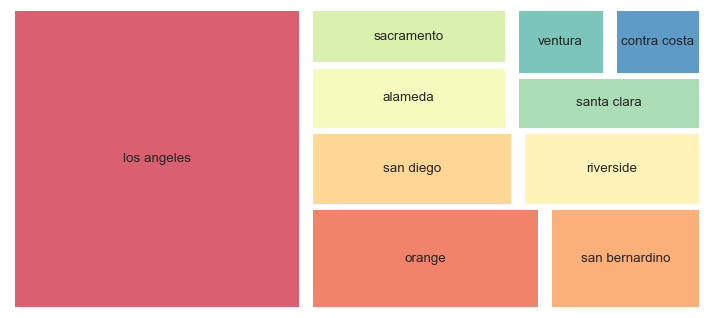

In [56]:
fig = plt.figure(dpi = dpi, figsize = (900 / dpi, 400 / dpi) )
squarify.plot(sizes=collisions['cnt'], label=collisions['county_location'], alpha=.8 ,color=sns.color_palette("Spectral",len(collisions)),pad=0.5,text_kwargs={'fontsize': 12,'wrap':True})
plt.axis('off')
plt.show()

Вот у нас есть топ-10 регионов с максимальным числом ДТП. Не удивительно что лидирует Лос-Анджелес - мегаполис с огромным количесвом машин, и следовательно и аварий тоже.

### 3.8 - Наиболее частые типы машин, попадающих в ДТП  <a name="section_3_8"></a>

Определим какие именно машины бьются больше всего. Характеризуем их по типу кузова и трансмиссии.
- Сделаем выгрузку из SQL.
- Посчитаетм число ДТП по получившимся типам машин.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [57]:
query = '''
SELECT DISTINCT
VEHICLE_TYPE,
VEHICLE_TRANSMISSION,
COUNT (case_id)  as cnt

FROM Vehicles
GROUP BY (VEHICLE_TYPE,VEHICLE_TRANSMISSION)
ORDER BY cnt;

'''
collisions= pd.read_sql_query(query, con=engine) 
collisions

,vehicle_type,vehicle_transmission,cnt
0,other,None,75
1,other,auto,430
2,other,manual,689
3,minivan,None,1915
4,hatchback,None,2016
5,minivan,auto,8234
6,sedan,None,8861
7,coupe,None,10792
8,hatchback,auto,18997
9,hatchback,manual,24582


<Axes: xlabel='vehicle_transmission', ylabel='vehicle_type'>

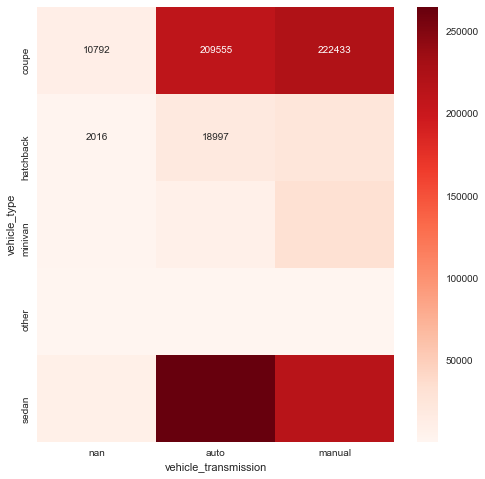

In [58]:
heat = collisions.pivot(index="vehicle_type", columns="vehicle_transmission", values="cnt")
plt.figure(figsize=(8, 8)) # задаём размер графика
sns.heatmap(heat, cmap='Reds',annot=True, # добавляем подписи
            fmt='')

Видно, что абсолютный рекордсмен по числу ДТП это седан с автоматической коробкой. Хотя по другим типам кузова АКПП заметно снижает учисло ДТП по сравнению с ручной коробкой (это может быть связано и с тем, таких машин просто намного меньше в исследуемом автопарке).

### 3.9 - Частота проблем с устройством управления  <a name="section_3_9"></a>

Определим насколько распространены проблемы с системой управления.
- Сделаем выгрузку из SQL.
- Посчитаетм число случаев проблем с системой управленя.
- Визуализируем результат как график или табилцу.
- Сделаем вывод.

In [59]:
query = '''
SELECT DISTINCT
control_device,
COUNT(c.CASE_ID)  as cnt
FROM collisions c INNER JOIN parties p ON c.CASE_ID=p.CASE_ID
WHERE party_type='car' AND at_fault=1
GROUP BY control_device
ORDER BY cnt
'''
collisions= pd.read_sql_query(query, con=engine) 
#Удалим пропуски
collisions

,control_device,cnt
0,obscured,654
1,not functioning,3220
2,None,6285
3,functioning,411402
4,none,818789


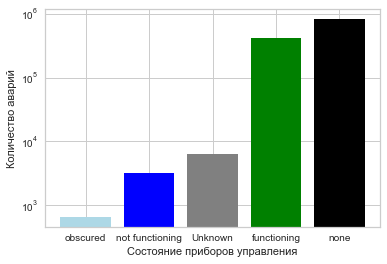

In [62]:
color = ['lightblue', 'blue', 'gray', 'green', 'black']
collisions['control_device'].fillna('Unknown', inplace=True)
fig, ax = plt.subplots()
ax.bar(collisions['control_device'], collisions['cnt'],
       color=color)
plt.yscale("log")
# Show graph
plt.ylabel('Количество аварий')
plt.xlabel('Состояние приборов управления')
plt.show()

В данных очень много пропусков. Но и с их учётом ясно, что проблемы с управлением встречаются очень редко, и основными виновником ДТП всё равно можно считать водителя. По крайней мере с точки зрения статистики вина автомоибля крайне редко встречается.

## Шаг 4 - Создание модели водительсткого риска  <a name="step4"></a>

### 4.1 - Выбор и загрузка данных  <a name="section_4_1"></a>


Теперь нам предостиот создать модель машинного обучнеия, способную с высокой вероятностью прогнозировать, станет ли арендатор каршерингового автомобиля всиновником ДТП.
Идя навстречу пожеланиям заказчика мы будем исследовать только данные за 2012 год, и только значительные повреждения. Дальше мы должны будем выбрать параметры, которые модель будет получать на входе, чтобы получить лучший прогноз.

Исходя из проведённых выше исследований, наиболее перспективными представляются факторы:

1) Фактры касающиеся машины:
- Возраст машины, всё-таки мы видели пик аварий для 3-5 летних машин;
- коробка передач - в большинстве случаев АКПП меньше бьются, если это не седан;
- тип кузова - мы видели, что седаны и купэ чаще других попадают в аварии;

2) Факторы касающиеся водителя:
- Уровень трезвости. Всё-таки доля пьяных аварий велика. Мы бы и наркотики включили, но нет способа быстро это измерить, можно узнать только после того как авария произошла.
- Страховая премия. Кто-то думает, что раз он застрахован, то может лихачить и уже ничем не рискует.

3) Факторы дорожной обстановки:
- Дата поездки. Есть ряд сезонных закономерностей. Попробуем  выделить из даты масяц, так как мы помним про пик аварий в октябре.
- Регион (county_city_location) - города отличаются и по климату и по качеству дорог и по контигенту и культуре вождения.
- Состояние дорожной поверхности - всё-таки мокрая дорога, это мокрая дорога, и процент аварий там заметно выше.
- Освещение. Достаточно заметный процент ДТП пришёлся у нас на ночь с электрическим освещением. А оно не везде одинаково и хорошо работает. Этот фактор может иметь вес, особенно в сочетании с мокрой дорогой.

In [63]:
query = '''
WITH Alice as (
SELECT c.case_id as key,
EXTRACT(YEAR FROM COLLISION_DATE) as YEAR,
TO_CHAR(COLLISION_DATE, 'Month') AS Month,
county_location, 
road_surface,
lighting,
insurance_premium,
party_sobriety,
party_number,
at_fault
FROM
collisions c JOIN parties p ON c.case_id=p.case_id
WHERE collision_damage NOT LIKE 'scratch' AND party_type='car' AND EXTRACT(YEAR FROM COLLISION_DATE)=2012.0)
SELECT 
* FROM (SELECT * FROM Alice inner join vehicles v ON Alice.key=v.case_id and Alice.party_number = v.party_number) Beta;
'''
df= pd.read_sql_query(query, con=engine) 
reserv=df
df

,key,year,month,county_location,road_surface,lighting,insurance_premium,party_sobriety,party_number,at_fault,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5454402,2012.0,January,san diego,dry,dark with street lights,NaN,impairment unknown,1,1,1326101,5454402,1,sedan,manual,3.0
1,5599532,2012.0,April,los angeles,None,daylight,46.0,had not been drinking,2,0,1463637,5599532,2,sedan,auto,0.0
2,5599669,2012.0,April,riverside,dry,daylight,42.0,had not been drinking,2,0,1463701,5599669,2,sedan,auto,5.0
3,5608541,2012.0,April,san bernardino,dry,daylight,33.0,had not been drinking,2,0,1471262,5608541,2,sedan,auto,5.0
4,5609086,2012.0,April,san luis obispo,dry,daylight,23.0,"had been drinking, under influence",1,1,1471785,5609086,1,sedan,auto,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5586872,2012.0,April,riverside,dry,dark with no street lights,50.0,had not been drinking,1,1,1451231,5586872,1,coupe,manual,8.0
56244,5586901,2012.0,April,santa cruz,dry,daylight,56.0,"had been drinking, under influence",1,1,1451261,5586901,1,coupe,manual,9.0
56245,5586927,2012.0,April,los angeles,wet,daylight,64.0,had not been drinking,1,1,1451286,5586927,1,coupe,manual,10.0
56246,5587003,2012.0,April,san diego,dry,dark with no street lights,24.0,"had been drinking, under influence",1,1,1451351,5587003,1,coupe,manual,3.0


In [64]:
df = df.loc[:,~df.columns.duplicated()].copy()
df=df.drop(['key', 'id','party_number','case_id','year'], axis=1)
df.sample(10)

,month,county_location,road_surface,lighting,insurance_premium,party_sobriety,at_fault,vehicle_type,vehicle_transmission,vehicle_age
6100,February,kern,dry,daylight,31.0,had not been drinking,1,sedan,auto,9.0
45245,May,orange,dry,dusk or dawn,67.0,had not been drinking,0,coupe,manual,10.0
33284,March,san luis obispo,dry,daylight,64.0,had not been drinking,0,coupe,manual,10.0
641,March,orange,dry,daylight,24.0,had not been drinking,0,sedan,manual,3.0
48321,March,los angeles,dry,dark with street lights,31.0,had not been drinking,1,sedan,auto,4.0
47074,January,los angeles,dry,daylight,19.0,had not been drinking,1,sedan,manual,3.0
17092,February,solano,dry,daylight,55.0,impairment unknown,1,sedan,manual,8.0
19272,April,los angeles,dry,daylight,20.0,had not been drinking,0,sedan,manual,0.0
45179,April,los angeles,dry,dark with street lights,24.0,impairment unknown,0,coupe,manual,3.0
43920,April,los angeles,dry,dark with street lights,23.0,had not been drinking,0,sedan,auto,0.0


In [65]:
cols=['month','party_sobriety', 'road_surface','vehicle_transmission','vehicle_type','county_location','road_surface','lighting']
for col in cols:
    df[col]=df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   month                 56248 non-null  category
 1   county_location       56248 non-null  category
 2   road_surface          55900 non-null  category
 3   lighting              56094 non-null  category
 4   insurance_premium     55701 non-null  float64 
 5   party_sobriety        55376 non-null  category
 6   at_fault              56248 non-null  int64   
 7   vehicle_type          56248 non-null  category
 8   vehicle_transmission  55389 non-null  category
 9   vehicle_age           54554 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 1.7 MB


### 4.2 - Анализ и предобработка набора данных  <a name="section_4_2"></a>

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

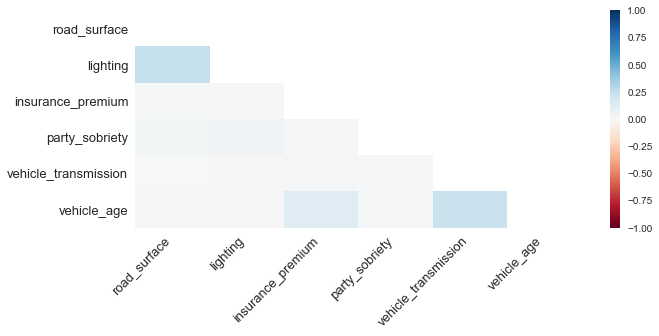

In [66]:
ydata_profiling.ProfileReport(df) 

Анализ набора данных показывает:
- Имеется небольшое количество дубликатов, их можно будет удалить без ущерба для качества данных.
- Есть некоторое количество пропусков, которое разнится от признака к признаку. Максимум в 3% наблюдается у возраста автомобиля. Остальные около 1-2%.
- В возрасте автомобилей есть аномальные всплески, противоречащие здравому смыслу. Например 2 автомобиля возрастом 161 год. Их можно будет удалить, так как они будут только провоцировать ошибку модели.
- Что касается размера страховки, то там есть тоже несколько экстремумова, которые статистически незначимы, но могут вводить модель в заблужение, их тоже слегка прижмём.
- Имеется кое-какая корреляция (0,572) между возрастом авто и страховой премией. Считаем, что это не критично и оба фактора можно оставить для моделирования.
- county_location - крайне разношёрстная категория, подавляющее большинтсво значений встречается разе чем в 2% случаях.


In [67]:
#Проверим наличие неявных дубликатов в столбце county_location
dedued=(list(process.dedupe(df['county_location'].unique(),threshold=90)))
count=0
for i in df['county_location'].unique():
    if i not in dedued:
        print(i)
        print(process.extractOne(i, dedued))
        count=count+1
if count==0:
    print("Нет неявных дубликатов")

Нет неявных дубликатов


In [68]:
df.shape

(56248, 10)

In [69]:
#Удалим пропуски:
dv=df.dropna()
#Удалим дубликаты
dv=dv.drop_duplicates()
#Ограничим выбросы
dv['vehicle_age']=dv['vehicle_age'].apply ( lambda x: x if x < 20 else 19)
dv['insurance_premium']=dv['insurance_premium'].apply ( lambda x: x if x < 69 else 69)
dv.shape

(45066, 10)

**Вывод:**

- Мы создали набор данных, содержащий признаки, которые скорее всего оказывают определяющее влияние на виновность водителя в ДТП.
- Набор получился достаточно качественный, и даже после чистки - достаточно большой чтобы обучать модели.
- Пропуски и явные дубликаты были удалены из набора данных.
- В колонке, содержащей возраст автомобиля была устранена аномалия - машины в возратсе старше 20 лет были признаны девятнадцатилетники. Но таких единицы.
- В колонке с размером страховой премии также были убраны несколько выбросов.

### 4.3 - Построение моделей без глубокого обучения  <a name="section_4_3"></a>

Начнём с того, что спрячем от всех моделей небольшой кусочек данных, чтобы потом на нём их сранивать и оценивать качество.

In [70]:
X_main, X_val = train_test_split(dv, test_size=0.1, random_state=42)

In [71]:
#Воспользуемся мощью библиотеки pycaret чтобы посмотреть какую предсказательную силу будут иметь типовые модели без глубокого обучения
exp = ClassificationExperiment()
exp = setup(data = X_main,  target = 'at_fault')
best_model = compare_models()

,Description,Value
0,Session id,6150
1,Target,at_fault
2,Target type,Binary
3,Original data shape,"(40559, 10)"
4,Transformed data shape,"(40559, 35)"
5,Transformed train set shape,"(28391, 35)"
6,Transformed test set shape,"(12168, 35)"
7,Ordinal features,1
8,Numeric features,2
9,Categorical features,7


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6485,0.7058,0.5534,0.6903,0.6142,0.2986,0.3048,0.2400
ada,Ada Boost Classifier,0.6469,0.7030,0.5480,0.6900,0.6108,0.2953,0.3020,0.1430
catboost,CatBoost Classifier,0.6412,0.6965,0.5479,0.6804,0.6069,0.2838,0.2895,0.9700
ridge,Ridge Classifier,0.6296,0.0000,0.4968,0.6844,0.5756,0.2614,0.2720,0.0450
xgboost,Extreme Gradient Boosting,0.6293,0.6834,0.5484,0.6610,0.5993,0.2599,0.2639,0.2810
lda,Linear Discriminant Analysis,0.6290,0.6842,0.4969,0.6833,0.5753,0.2603,0.2707,0.0650
lr,Logistic Regression,0.6280,0.6844,0.5062,0.6769,0.5792,0.2580,0.2669,0.9090
nb,Naive Bayes,0.5987,0.6596,0.2703,0.8118,0.4042,0.2034,0.2743,0.0450
qda,Quadratic Discriminant Analysis,0.5871,0.6485,0.3331,0.7873,0.4215,0.1787,0.2447,0.0560
knn,K Neighbors Classifier,0.5791,0.6110,0.5415,0.5916,0.5654,0.1588,0.1594,0.2540


1) Лучшие из постренных моделей дают предсказательную способность на уровне 69-70 по AUC. Данный показатель представляется нам наиболее важным для оценки качества модели, так как учитывает ошибку и первого и второго типа. 
2) Печально, что лучшую метрику RECALL=1,0 показывает "примитивный" алгоритм, который всегда говорит одно и тоже. В результате он попадает ровно в половине случаев, но угадывает при этом 100% случаев, когда вина действительно была. Более успешные алгоритым не угадывают более 62%, что печально.
3) Есть небольшая надежда на тюнинг гипер-параметров, но он обычно добавляет не более нескольких процентов к целевой метрике.
4) Есть несколько большая надежда на нейросеть с глубоким обучением. Может быть она сможет показать метрики лучше.

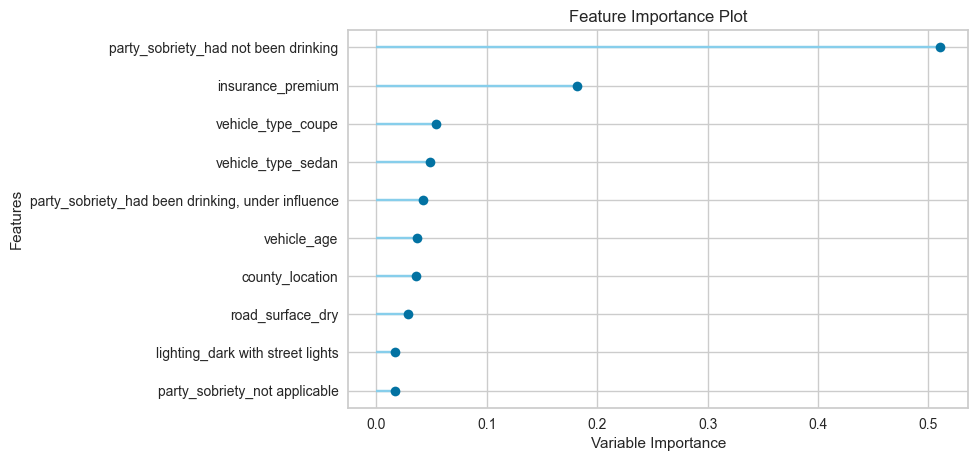

In [72]:
plot_model(best_model, plot = 'feature')

Среди отобранных нами факторов есть прямо два, которые имеют очень сильный вес о определении вины водителя - это алкогольное опьянение и размер старховой премии. Но они вместе имеют важность в районе 60%, что значит что без остальных признаков модели точного результата не получить. Исключить можно пожалуй только тип коробки передач и дату происшествия, их вес не вошёл в ТОП-10 и его исключение скорее всего никак не скажется на качестве моедли.

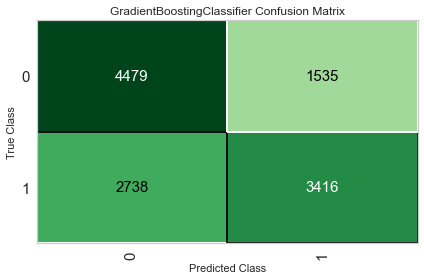

In [73]:
plot_model(best_model, plot = 'confusion_matrix')

Видно, когда показатель at_fault=1 - модель определяет это правильно лишь на 20% чаще, чем ошибается. Когда at_fault=0, соотношение примерно 3 к 1 в пользу правильных ответов. Это говорит о том, что классификация не очень точная и надо оптимизировать модель.

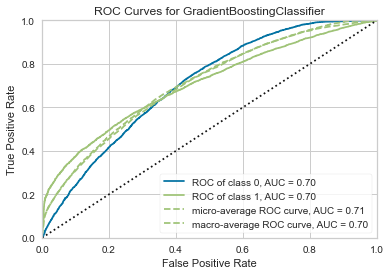

In [74]:
plot_model(best_model, plot = 'auc')

In [75]:
best_model_results = pull()

Прошлый вывод подтверждается графиком, площадь по кривой далека от 1. По факту она даже ближе к "примитивному" решению, чем к идеальному.

In [76]:
#Для тюнинга гипер-параметров выберем модель AdaBoostingClassifier. Он даёт почти такие же результаты как наш лидер Gradient Boosting Classifier, но учиться гораздо быстрее
test_model = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6479,0.7006,0.5460,0.6926,0.6106,0.2974,0.3044
1,0.6312,0.6917,0.5376,0.6684,0.5959,0.2640,0.2693
2,0.6442,0.7020,0.5369,0.6909,0.6042,0.2902,0.2979
3,0.6611,0.7126,0.5682,0.7047,0.6291,0.3237,0.3301
4,0.6404,0.6954,0.5299,0.6874,0.5985,0.2826,0.2904
5,0.6471,0.7002,0.5306,0.6991,0.6033,0.2960,0.3052
6,0.6499,0.7036,0.5627,0.6882,0.6192,0.3012,0.3064
7,0.6354,0.7001,0.5376,0.6754,0.5987,0.2725,0.2785
8,0.6541,0.7083,0.5731,0.6904,0.6263,0.3095,0.3142


In [77]:
test_model = tune_model(test_model, optimize = 'AUC',search_library = 'optuna',n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6507,0.7015,0.5529,0.6941,0.6155,0.3029,0.3095
1,0.6365,0.6934,0.5404,0.6760,0.6006,0.2746,0.2804
2,0.6397,0.7039,0.5320,0.6852,0.5990,0.2811,0.2886
3,0.6573,0.7145,0.5606,0.7018,0.6233,0.3161,0.3228
4,0.6379,0.6981,0.5320,0.6821,0.5978,0.2776,0.2847
5,0.6492,0.7033,0.5341,0.7011,0.6063,0.3002,0.3093
6,0.6513,0.7040,0.5606,0.6916,0.6192,0.3040,0.3097
7,0.6393,0.7007,0.5439,0.6791,0.6040,0.2802,0.2860
8,0.6488,0.7102,0.5675,0.6843,0.6205,0.2990,0.3035


[I 2024-01-26 13:48:16,053] Searching the best hyperparameters using 28391 samples...
[I 2024-01-26 13:49:13,167] Finished hyperparameter search!


In [78]:
test_model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=0.42088295695801886,
                   n_estimators=279, random_state=6150)

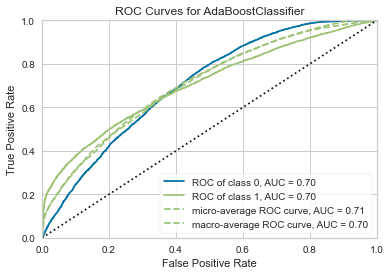

In [79]:
plot_model(test_model, plot = 'auc')

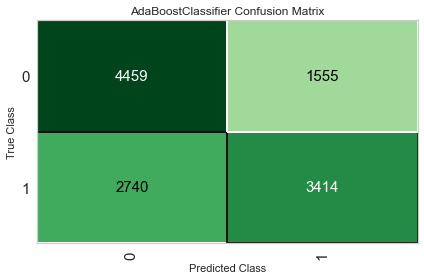

In [80]:
plot_model(test_model, plot = 'confusion_matrix')

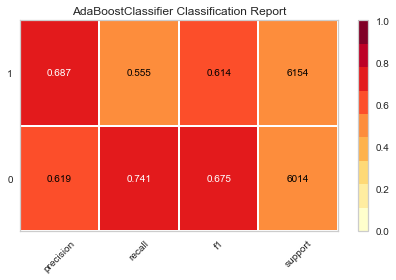

In [81]:
plot_model(test_model, plot = 'class_report')

In [82]:
tuned_model_results = pull()

**Вывод - оптимизация гипер-параметров не принесла никакого результата. По факту без него было даже лучше.**

In [83]:
#Последняя попытка улучшить результаты - собрать комплекс из опробованных моделей, из из их показаний постараться выбрать самое удачное
best_recall_models_top3 = compare_models(sort = 'Recall', n_select = 3)
stacked_model_=stack_models(best_recall_models_top3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5058,0.5000,1.0000,0.5058,0.6718,0.0000,0.0000,0.0450
svm,SVM - Linear Kernel,0.5675,0.0000,0.6267,0.6656,0.5499,0.1330,0.1685,0.1430
gbc,Gradient Boosting Classifier,0.6485,0.7058,0.5534,0.6903,0.6142,0.2986,0.3048,0.2370
xgboost,Extreme Gradient Boosting,0.6293,0.6834,0.5484,0.6610,0.5993,0.2599,0.2639,0.2310
ada,Ada Boost Classifier,0.6469,0.7030,0.5480,0.6900,0.6108,0.2953,0.3020,0.1570
rf,Random Forest Classifier,0.5667,0.5976,0.5479,0.5752,0.5612,0.1338,0.1340,0.2360
catboost,CatBoost Classifier,0.6412,0.6965,0.5479,0.6804,0.6069,0.2838,0.2895,0.9690
knn,K Neighbors Classifier,0.5791,0.6110,0.5415,0.5916,0.5654,0.1588,0.1594,0.1080
et,Extra Trees Classifier,0.5533,0.5554,0.5351,0.5612,0.5478,0.1069,0.1070,0.2710
dt,Decision Tree Classifier,0.5330,0.5328,0.5247,0.5394,0.5319,0.0661,0.0662,0.0590


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6514,0.7018,0.5641,0.6899,0.6207,0.3042,0.3095
1,0.6347,0.6948,0.5815,0.6570,0.6169,0.2703,0.2722
2,0.6368,0.7006,0.5390,0.6772,0.6002,0.2753,0.2814
3,0.6569,0.7143,0.5773,0.6931,0.6299,0.3151,0.3197
4,0.6421,0.7002,0.5571,0.6780,0.6116,0.2857,0.2904
5,0.6478,0.7022,0.5446,0.6933,0.6100,0.2972,0.3044
6,0.6435,0.7025,0.5703,0.6746,0.6181,0.2883,0.2918
7,0.6407,0.7031,0.5508,0.6784,0.6080,0.2829,0.2882
8,0.6502,0.7117,0.5864,0.6785,0.6291,0.3015,0.3044


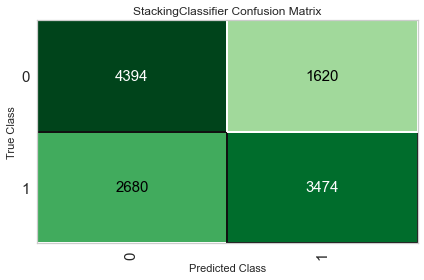

In [84]:
plot_model(stacked_model_, plot = 'confusion_matrix')

**Вывод**

Мы видем,что моделирование без нейронных сетей упёрлось в качественный потолок. Особенно печальным явялется то, что показатель Recall - а именно процент верно угаданных реальных виновников ДТП достаточно низок, если не считать DummyClassifier. Посмотрим, может быть глубокое обучение позволит нам повысить этот показатель.

### 4.4 - Построение модели глубокого обучения  <a name="section_4_4"></a>

In [85]:
#Здадим консатны для воспроизоводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
random_state=42


In [86]:
num_c=['insurance_premium','vehicle_age']
cat_c=['month','party_sobriety', 'road_surface','vehicle_transmission','vehicle_type','county_location','road_surface','lighting']

In [87]:
#Попробуем задействовать видеокарту для ускорения обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
#Завернём всю оставшуюся предобработку в одну функцию, чтобы потом использовать для обработки разных выборок

def pipelining(d,sc,ohe):
    #Процедура стандартизации количественных и "горячего" кодирования категориальных переменных
    d[num_c]=sc.transform(d[num_c])
    dc=ohe.transform(d[cat_c]).toarray()
    cols=[]
    for c in range(len(cat_c)):
        result = [str(cat_c[c])+"_" + str(type) for type in (ohe.categories_[c].tolist())]
        cols=cols+result
    dc=pd.DataFrame(dc,columns=cols,index=d.index)
    d = pd.concat([d, dc], axis=1,ignore_index=False, sort=False)
    d=d.drop(cat_c, axis=1)   
    return d

In [89]:
# Осуществим разделение данных на выборки с использованием случайного страйнинга
train_indices, test_indices = train_test_split(np.arange(X_main.shape[0]), test_size=0.2, random_state=42)
# Создание двух выборок
train_data = X_main.iloc[train_indices]
test_data = X_main.iloc[test_indices]
#Предобработка данных
sc=StandardScaler()
ohe=OneHotEncoder(handle_unknown='ignore')
sc.fit(train_data[num_c])
ohe.fit(train_data[cat_c])
    
df_train=pipelining(train_data,sc,ohe)
df_test=pipelining(test_data,sc,ohe)

#Отедляем фичи от таргета
X_train=df_train.drop(columns=['at_fault'])
features=X_train.columns
n_in_neurons = X_train.shape[1]
X_test=df_test.drop(columns=['at_fault'])     
y_train = df_train['at_fault']
y_test = df_test['at_fault']
#Переводим дата-фреймы в тензоры

X_train = torch.FloatTensor(np.ascontiguousarray(X_train,dtype = np.float32))
X_test = torch.FloatTensor(np.ascontiguousarray(X_test,dtype = np.float32))
y_train = torch.FloatTensor(np.ascontiguousarray(y_train,dtype = np.float32))
y_test = torch.FloatTensor(np.ascontiguousarray(y_test,dtype = np.float32))

In [90]:

n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 4
n_out_neurons = 1 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
#Создадим пробную архитектуру нейросети
net1 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.Sigmoid()
).to(device)


In [92]:
optimizer = torch.optim.Adam(net1.parameters(), lr=1.0e-3) 
loss = nn.BCELoss()
num_epochs = 1000

In [93]:
#Добавим опцию ранней остановки, если целевая метрика не стабилизировалась и не улучшается
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = 0

    def early_stop(self, validation_loss):
        if validation_loss > self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss < (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [94]:
#Как было сказано, мы хотим увеличить процент правильно угаданных моделью виновников ДТП, для этого нам понадобится функция расчёта метрики Recall
def recall_tensors(outputs, targets):
    predicted_labels = torch.round(outputs)
    predicted_labels=torch.tensor(predicted_labels, dtype=torch.int16)

    true_positives = (predicted_labels == targets).sum().item()
    false_negatives = torch.logical_and(predicted_labels == 0, targets == 1).sum().item()
    return true_positives / (true_positives + false_negatives)

In [95]:
#Проведёт первичное обучение нейросети
for epoch in range(num_epochs):
	net1.train()
	optimizer.zero_grad()
	preds = net1.forward(X_train.to(device)).flatten()
	loss_value = loss(preds, y_train.to(device))
	loss_value.backward()
	optimizer.step()
	early_stopper = EarlyStopper(patience=10, min_delta=0.001)
	if epoch % 100 == 0 or epoch == 1000:
		net1.eval()
		test_preds = net1.forward(X_test.to(device))

        #Посчитаем метрику на тестовых данных
		accuracy = recall_tensors(test_preds,y_test.to(device))
		sys.stdout.write('\r epoch:'+str(epoch)+'// recall test:' + str(accuracy))
		if early_stopper.early_stop(accuracy):             
			print('Early Stoppning!!!')
			print(f'Last recall test {accuracy}')
			break

 epoch:900// recall test:0.6271281152604441

In [96]:
preds=net1.forward(X_test.to(device))
accuracy = recall_tensors(preds,y_test.to(device))
preds=torch.Tensor(preds).cpu()
preds=np.round(preds.detach().numpy(), 0)
roc_auc_=roc_auc_score(y_test.detach().numpy(), preds)
print("roc_auc=",roc_auc_," recall=",accuracy)

roc_auc= 0.6453308949802722  recall= 0.6269271282912064


С ходу мы смогли получить значение Recall выше чем у моделей без глубокого обучения. Постараемся улучшить результат за счёт оптимизации архитектуры сети и гипер-параметров.

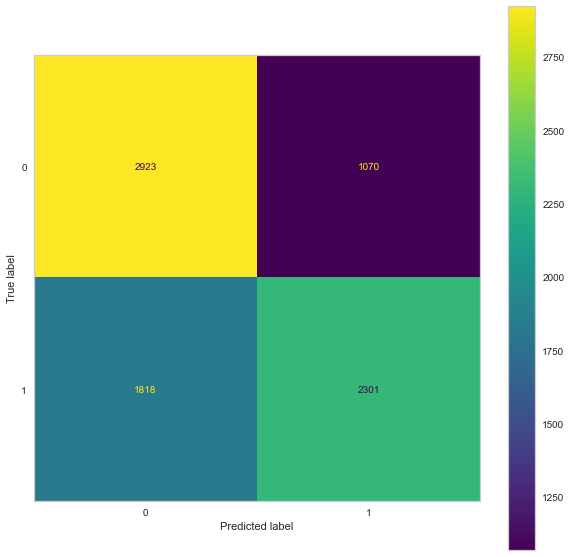

In [97]:
cm = confusion_matrix(y_test.detach().numpy(), preds)
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
ConfusionMatrixDisplay(cm).plot(ax=ax)

Матрица ошибок всё ещё говорит, что мы достаточно часто ошибаемся с истинным виновником ДТП.

## Шаг 5 - Поиск лучшей модели  <a name="step5"></a>

### 5.1 - Оптимизация архитерктуры модели с помощью библиотеки optuna  <a name="section_5_1"></a>

In [98]:
def define_model(trial):
    # Оптимизируем количество слоёв и нейронов в них
    n_layers = trial.suggest_int("n_layers", 2, 6)
    layers = []

    in_features = n_in_neurons
    layers.append(nn.BatchNorm1d(in_features))

    
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 64)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        #проведём дополнительную регуляризацию подобрав значение слоя с выпадающими нейронами
        if i==1:
            p = trial.suggest_float("dropout_l{}".format(i), 0.4, 0.99)
            layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())
            # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.TrialPruned()

    return nn.Sequential(*layers)

In [99]:
def optimize_structure(trial):

    n_out_neurons = 1

    net2 = define_model(trial).to(device)
    optimizer = torch.optim.Adam(net2.parameters(), lr=0.018, weight_decay=1e-2) 
    loss = nn.BCELoss()

    num_epochs = 1000

    early_stopper = EarlyStopper(patience=3, min_delta=0.0001)
    for epoch in range(num_epochs):
        net2.train()
        optimizer.zero_grad()
        preds = net2.forward(X_train.to(device)).flatten()
        loss_value = loss(preds, y_train.to(device))
        loss_value.backward()
        optimizer.step()
        preds=torch.Tensor(preds).cpu()
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        if epoch % 100 == 0 or epoch == 10000:
            net2.eval()
            test_preds = net2.forward(X_test.to(device))
            accuracy = recall_tensors(test_preds,y_test.to(device))
            sys.stdout.write('\r epoch:'+str(epoch)+'// recall test:' + str(accuracy))
            roc_auc_=roc_auc_score(y_test.detach().numpy(), test_preds.cpu().detach().numpy())
            if early_stopper.early_stop(roc_auc_):             
                break

    return roc_auc_

In [100]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_structure, n_trials=20, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

 epoch:400// recall test:0.5891872073765345Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.6908867648756774
  Params: 
    n_layers: 3
    n_units_l0: 25
    n_units_l1: 53
    dropout_l1: 0.48855627915181443
    n_units_l2: 55


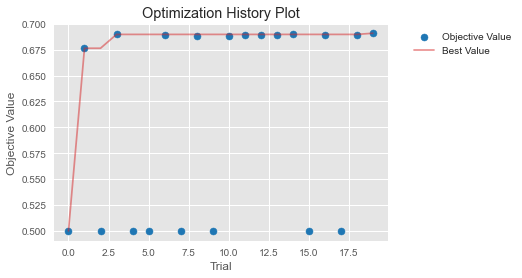

In [105]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

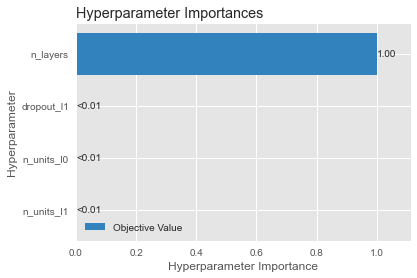

In [106]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

Мы получили новую и более сложную структуру модели, которая должна улучшить наши метрики, в частности Recall. Но результат можно будет улучшить ещё, используя лучшие гипер-парамтеры.

### 5.2 - Подбор гипер-параметров  <a name="section_5_2"></a>

In [107]:
#Напишем процедуру, которая будут создавать на модель, принимая на вход кое-какие гипер-параметры, которые мы потом будем оптимизировать
def customize_model(ins=20,layers=2,neurons=[8,4],drops=0.5):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = layers
    layers = []
    in_features = ins
    layers.append(nn.BatchNorm1d(in_features))
   
    for i in range(n_layers):
        out_features = neurons[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        if i==1:
            layers.append(nn.Dropout(drops))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [108]:
layers=list(trial.params.items())[0][1]
neuro_list=[]
for i in range(layers+1):
    if i!=2:
        neuro_list.append(list(trial.params.items())[1+i][1])
drop=list(trial.params.items())[3][1]

In [109]:
def optimize_params(trial):
    # Инициализируем модель
    net0 =  customize_model(ins=n_in_neurons,layers=layers,neurons=neuro_list,drops= drop).to(device)
    loss = nn.BCELoss()
    # Протестируем набор оптимизаторов и скоростей обучения
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 3e-4, 0.999, log=True)
    
    optimizer = getattr(optim, optimizer_name)(net0.parameters(), lr=lr,weight_decay=1e-2)

    # Обучение модели
    EPOCHS=trial.suggest_int("EPOCHS", 200,2000)

    cr=trial.suggest_int("calibration_rate", 20,100)
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)
    #X_test,y_test, train_dataloader, test_dataloader=create_loaders(df,BATCHSIZE)
    for epoch in range(EPOCHS):
        net0.train()
        optimizer.zero_grad()
        predz = net0.forward(X_train.to(device)).flatten()
        loss_value = loss(predz, y_train.to(device))
        loss_value.backward()
        optimizer.step()
    
        if epoch % cr == 0:
            rc=recall_tensors(predz,y_train.to(device))

            net0.eval()
            test_preds = net0.forward(X_test.to(device))
            accuracy = recall_tensors(test_preds,y_test.to(device))
            sys.stdout.write('\r epoch:'+str(epoch)+'// Recall test:' + str(accuracy))

            if early_stopper.early_stop(accuracy):             
                break
        if trial.should_prune():
            raise optuna.TrialPruned()
    preds=net0.forward(X_test.to(device))
    preds=torch.Tensor(preds).cpu()
    preds=np.round(preds.detach().numpy(), 0)
    roc_auc_=roc_auc_score(y_test.detach().numpy(), preds)
    preds=net0.forward(X_test.to(device))
    recz=recall_tensors(preds,y_test.to(device))
    if recz>0.90:
        raise optuna.TrialPruned()

    return recz

In [110]:
# Инициализируем модель
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_params, n_trials=50, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials)) 
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

 epoch:105// Recall test:1.0Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  18
  Number of complete trials:  32
Best trial:
  Value:  0.8765082252027947
  Params: 
    optimizer: SGD
    lr: 0.030829796234900647
    EPOCHS: 693
    calibration_rate: 33


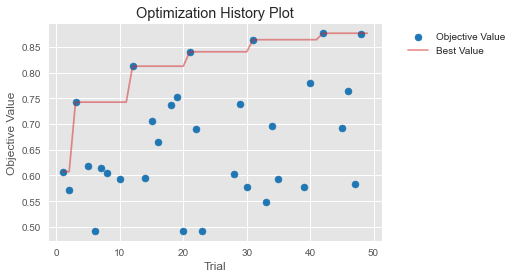

In [111]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [112]:
list(trial.params.items())

[('optimizer', 'SGD'),
 ('lr', 0.030829796234900647),
 ('EPOCHS', 693),
 ('calibration_rate', 33)]

In [113]:
opt=list(trial.params.items())[0][1]
lr=list(trial.params.items())[1][1]
ep=list(trial.params.items())[2][1]
cr=list(trial.params.items())[3][1]

In [114]:
net3=customize_model(n_in_neurons,layers=layers,neurons=neuro_list,drops= drop).to(device)

optimizer = getattr(optim, opt)(net3.parameters(), lr=lr,weight_decay=1e-2)
loss = nn.BCELoss()

num_epochs = cr*50

val_loss = []
train_loss = []
early_stopper = EarlyStopper(patience=10, min_delta=0.001)
for epoch in range(num_epochs):
    net3.train()
    optimizer.zero_grad()
    predz = net3.forward(X_train.to(device)).flatten()
    loss_value = loss(predz, y_train.to(device))
    loss_value.backward()
    optimizer.step()
    #preds=torch.Tensor(preds).cpu()
    if cr>num_epochs/2:
        cr=ep/3
    if epoch % cr == 0:
        rc=recall_tensors(predz,y_train.to(device))
        train_loss.append(rc)
        net3.eval()
        test_preds = net3.forward(X_test.to(device))
        accuracy = recall_tensors(test_preds,y_test.to(device))
        sys.stdout.write('\r epoch:'+str(epoch)+'// Recall test:' + str(accuracy))
        val_loss.append(accuracy)
        if early_stopper.early_stop(accuracy):             
            print('Early Stoppning!!!')
            print(f'Last Recall test {accuracy}')
            break

 epoch:330// Recall test:0.812820166650731Early Stoppning!!!
Last Recall test 0.812820166650731


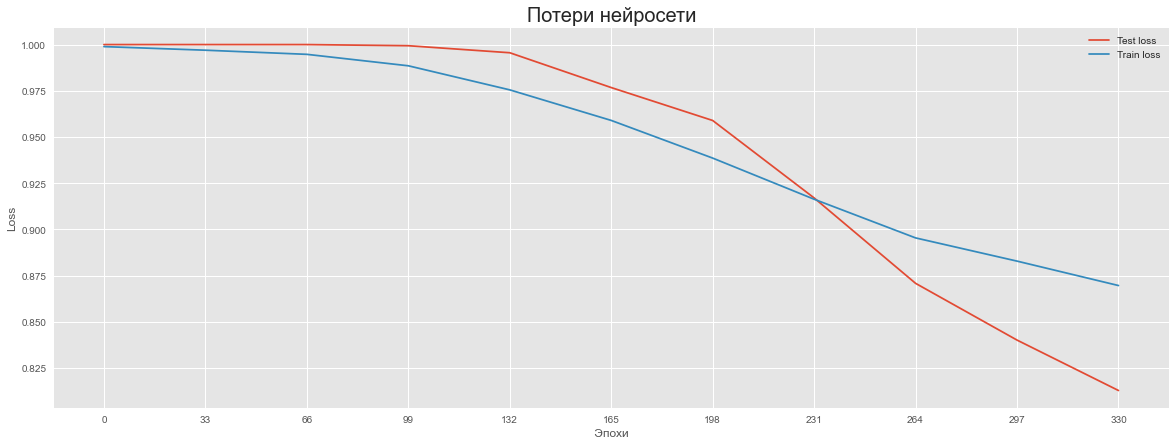

In [116]:
x = np.arange(len(val_loss))
labels=x*cr

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(7)
ax.set_xticks(labels)
val = ax.plot(labels, val_loss, label = 'Test loss')
train = ax.plot(labels, train_loss, label = 'Train loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel(str(' Эпохи '))
ax.set_ylabel('Loss')
plt.show()

In [117]:
preds=net3.forward(X_test.to(device))
recall_tensors(preds,y_test.to(device))

0.812820166650731

In [118]:
preds=torch.Tensor(preds).cpu()
preds=np.round(preds.detach().numpy(), 0)
roc_auc_=roc_auc_score(y_test.detach().numpy(), preds)
roc_auc_

0.5488052744889136

**Выводы:**
После оптимизации модель стала с уже гораздо большей точностью определять виновника ДТП, кода он садится за руль. При этом невиновных она всё ещё не очень сильно дискриминирует без достаточных на то оснований. Но прежде чем перейти к выводам, необходимо ещё раз сравнить результаты всех натренированных ранее моделей.


### 5.3 - Сравнение результатов моделирования  <a name="section_5_3"></a>

In [119]:
full_test_pred=predict_model(best_model,X_val)['prediction_label']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6452,0.7017,0.5526,0.6909,0.6140,0.2932,0.2995


In [120]:
eva=pd.DataFrame(columns=['Model','Accuracy','AUC','Recall','Prec.','F1'])
y_val=X_val['at_fault']
models={'Gradient Boosting Classifier':best_model,"Ada Boosting with tuning":test_model,'Stack of models without deep learning':stacked_model_}
for m in models.keys():
    full_test_pred=predict_model(models[m],X_val,verbose=0)['prediction_label']
    m1=accuracy_score(y_val,full_test_pred)
    m2 = roc_auc_score(y_val, full_test_pred)
    m3 = recall_score(y_val, full_test_pred)
    m4 = precision_score(y_val, full_test_pred)
    m5 = f1_score(y_val, full_test_pred)
    eva=eva.append(pd.Series([m, m1,m2,m3,m4,m5], index=eva.columns), ignore_index=True)
eva

,Model,Accuracy,AUC,Recall,Prec.,F1
0,Gradient Boosting Classifier,0.645219,0.647257,0.552563,0.690929,0.614048
1,Ada Boosting with tuning,0.640559,0.642657,0.545178,0.686543,0.607748
2,Stack of models without deep learning,0.643444,0.645347,0.556907,0.685928,0.614721


In [121]:
df_val=pipelining(X_val,sc,ohe)

#Отедляем фичи от таргета
X_val1=df_val.drop(columns=['at_fault'])
y_val1 = df_val['at_fault']
#Переводим дата-фреймы в тензоры

X_val1 = torch.FloatTensor(np.ascontiguousarray(X_val1,dtype = np.float32))
y_val1 = torch.FloatTensor(np.ascontiguousarray(y_val1,dtype = np.float32))

In [122]:
models={'Raw Neuronet':net1,"Optimized Neuronet":net3}

for m in models.keys():
    full_test_pred=models[m].forward(X_val1.to(device)).flatten()
    full_test_pred =torch.Tensor(full_test_pred).cpu()
    full_test_pred=np.round(full_test_pred.detach().numpy(), 0)
    m1=accuracy_score(y_val1.detach().numpy(),full_test_pred)
    m2 = roc_auc_score(y_val1.detach().numpy(), full_test_pred)
    m3 = recall_score(y_val1.detach().numpy(), full_test_pred)
    m4 = precision_score(y_val1.detach().numpy(), full_test_pred)
    m5 = f1_score(y_val1.detach().numpy(), full_test_pred)

    eva=eva.append(pd.Series([m, m1,m2,m3,m4,m5], index=eva.columns), ignore_index=True)

In [123]:
numeric_columns=['AUC','Recall']
eva.style.highlight_null(null_color='lightgrey').highlight_max(color='yellowgreen', subset=numeric_columns).highlight_min(color='coral', subset=numeric_columns).highlight_max(color='green', subset=['F1'])

,Model,Accuracy,AUC,Recall,Prec.,F1
0,Gradient Boosting Classifier,0.645219,0.647257,0.552563,0.690929,0.614048
1,Ada Boosting with tuning,0.640559,0.642657,0.545178,0.686543,0.607748
2,Stack of models without deep learning,0.643444,0.645347,0.556907,0.685928,0.614721
3,Raw Neuronet,0.631684,0.633529,0.547785,0.670745,0.603061
4,Optimized Neuronet,0.551586,0.545689,0.819722,0.540223,0.651251


**Выводы**

- 1. В итоге мы получили нейросеть, которая имеет максимальные из возможных метрики по F1 и Recall.
- 2. Такая сеть способна более чем в 81% случаев определить потенциального виновника ДТП, заблаговременно. При этом, в случае когда модель ошибочно считает, что вина в ДТП будет, встречаются достаточно редко, что подтверждается максимальным значением F1.
- 3. В данном случае нейросети не дают заметного выиграша в метриках, при этом гораздо более затраты по времени и машинным ресурсам.


## Шаг 6 - Проверка лучшей модели в работе  <a name="step6"></a>

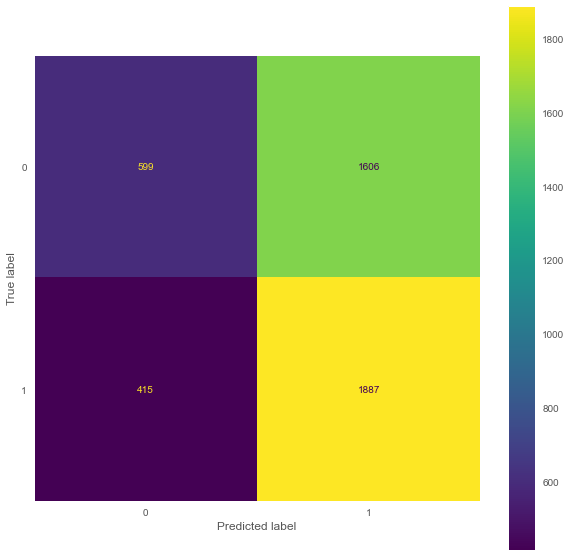

In [124]:
full_test_pred=net3.forward(X_val1.to(device))
full_test_pred =torch.Tensor(full_test_pred).cpu()
rounded_test_pred=np.round(full_test_pred.detach().numpy(), 0)
cm = confusion_matrix(y_val1.detach().numpy(), rounded_test_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
ConfusionMatrixDisplay(cm).plot(ax=ax)

Матрица ошибок подтвержадет, что нам удалось свести ошибки и первого и второго типа к минимуму. Конечно, ошибки встречаются. Даже у самого пьяного водителя может случиться удачный день. Но такая точность прогноза уже позволит компании лучше контролировать риски.

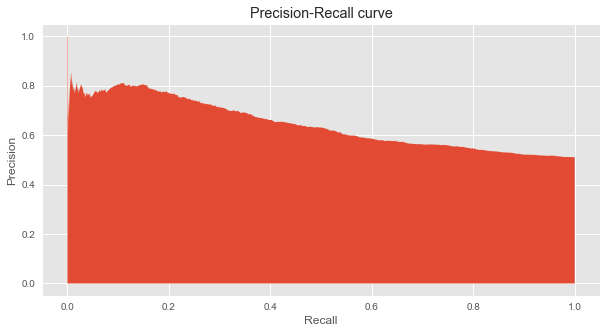

In [125]:

precision, recall, thresholds = precision_recall_curve(y_val1.detach().numpy(), net3.forward(X_val1.to(device)).cpu().detach().numpy())
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(10)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve");

График показывает, что полнота и точность далеки от идеала, но для такой неструктурированной задачи это естественно.
На графике видно, что модель легко может достигать высокой точности, но при этом полнота будет сильно проваливаться, что с экономической точки зрения неприемлемо.


In [126]:
%%time
x_samples = X_train[np.random.choice(np.arange(len(X_train)), 300, replace=False)]
x_samples = x_samples[:, 0:5000]
print(len(x_samples))
e = shap.DeepExplainer(net3,x_samples.to(device))
shap_values = e.shap_values(x_samples.to(device))

300
Wall time: 2 s


In [127]:
f = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": features
})
f.sort_values("mean_abs_shap", ascending=False)[:10]

,mean_abs_shap,stdev_abs_shap,name
25,0.001028,0.000303,vehicle_transmission_manual
17,0.000852,0.001084,party_sobriety_had not been drinking
28,0.000839,0.000433,vehicle_type_sedan
74,0.000745,0.006418,county_location_sierra
83,0.000677,0.003332,county_location_tuolumne
16,0.000656,0.001196,"party_sobriety_had been drinking, under influence"
61,0.000636,0.001186,county_location_riverside
79,0.000599,0.003636,county_location_sutter
45,0.000480,0.002909,county_location_lake
6,0.000479,0.000496,month_January


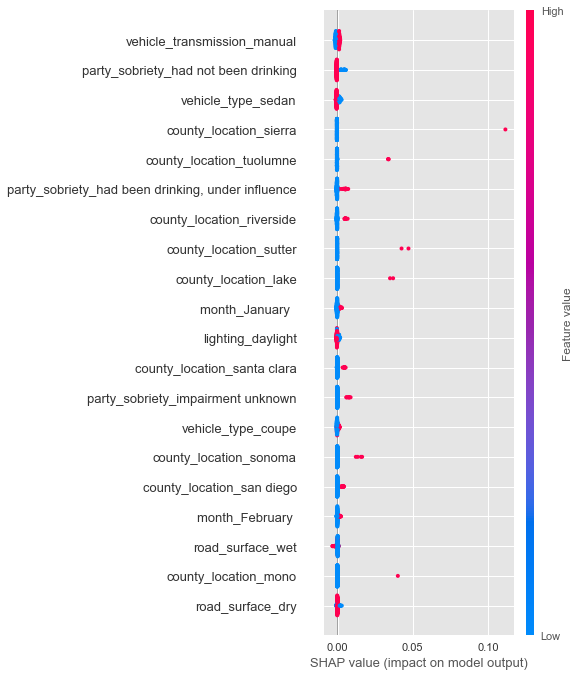

In [128]:
shap.summary_plot(shap_values, features=x_samples, feature_names=features)

Как и в предыдущих случая - наиболее влиятельные факторы этотрезвость водителя, а также ручная коробка передач и тип машины - седан, как самый распространённый. Возраст машины влияет крайне слабо - даже в десятку не входит.

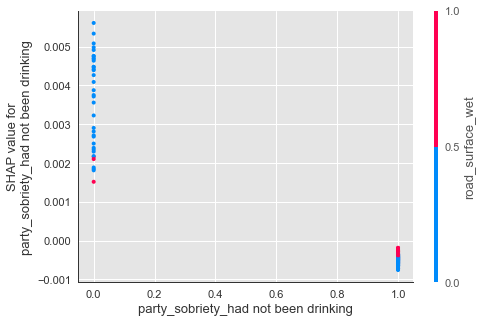

In [129]:
shap.dependence_plot('party_sobriety_had not been drinking', shap_values, x_samples.detach().numpy(), feature_names=features)

График зависимости  целевой переменной (at_fault) от факторы "party_sobriety_had not been drinking", а проще говоря от факта трезвости водителя, чётко показывает, что на отсутствие вины фактор влияет очень сильно, а на наличие - крайне мало.

## Шаг 7 - Общий вывод по работе  <a name="step7"></a>

- 1). Получилась нейронная сеть из трёх слоёв с регуляризацией (нормализация входных данных, выпадающий слой и корректировка весов модели, для защиты от переобучения). Модель имеет переков в сторону метрики Recall, т.е. старается как можно точнее угадать будущего виновника ДПТ, и платит за это тем, что чаще ошибается в тех случаях, когда водитель для неё подозрителен, но всё-таки невиновен. 
- 2) На текущем технологическом уровне трудно говорить о совсем уж адекватной системе оценке риска при выдаче авто. Слишком велик субъективный фактор, который трудно оценить исходя из того что объективно и наблюдаемо.
- 3) В качестве рекомендаций для будущего улучшения модели, есть смысл:

а) накапливать статистику по пользователям, если они за рулём нашего кар-шеринго не первый раз, то данные о прошлых поездках могут оказаться полезными;

б) подкачивать данные из других источников. Например от правоохранительных органов, о количестве полученных штрафов за нарушения ПДД;

в) можно использовать информацию, которая появляется после того как поездка началась, например анализировать маршрут и скорость, чтобы оценить агрессивность вождения, которая безусловно может стать причиной ДТП.
